### Logistic Regression models

**Objective**: This notebook aims to analyse customer reviews using Logistic Regression models to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed Logistic Regression with L1 regularisation to optimise the model's performance, which helps in feature selection by penalising less important features. The data is vectorised using 1 and 2-grams to capture the context within the text effectively. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset (Balanced and unbalanced) and compare the results.

**Key Findings**: The top three words associated with positive reviews are "love", "great" and "perfect". The top three words associated with negative reviews are "return", "broke" and "waste". This is consistant between both models. We are focusing on being able to **correctly identify negative reviews** and to infer the most common issues cutsomers have with products. So I will quote the recall of class 0: The model on unbalanced data scored an recall of $0.31$, and the model on balanced data achieved a recall of $0.83$. More analysis takes place in the notebook.

In [163]:
# standard library imports
import joblib

# data handling and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (20, 10)

# machine learning and utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

# local source imports
from source import downsample_binary, my_tokenizer

# interpretability tools
import lime
import lime.lime_tabular

In [6]:
# feature union for the vectoriser, easiest way to guarantee 500 1-grams and 100 2-grams 
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

Begin by reading in the data, then I will optimise for best C value using $L1$ Regression. Before doing this, I will split the data into test and train, and make a copy of the train set before downsampling the majority class. I will train two logistic regressions on each dataset and compare the results. I am using the vectorisation with 1 and 2-grams

In [7]:
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")

In [8]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# this is used in evaluation
test_later = X_test

In [10]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

I keep an unvectorised train set and a prevectorised train set so that we can tune the hyperparamters with out having to apply the vectoriser every cross-validation, saving compute. I recognise that this leaks the validation set, however, the test set is kept hidden til evaltuation. 


In [11]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [12]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]



After binning the reviews rated 1,2 or 3 stars together as "0" or negative, and the reviews rated 4 or 5 stars as "1" or positive, the distribution below:

In [13]:
y_train.value_counts(normalize=True), y_train_bal.value_counts(normalize=True)

(binary
 1    0.761183
 0    0.238817
 Name: proportion, dtype: float64,
 binary
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

In [14]:
# checking that the downsample worked
y_train.value_counts(), y_train_bal.value_counts()

(binary
 1    432829
 0    135798
 Name: count, dtype: int64,
 binary
 0    135798
 1    135798
 Name: count, dtype: int64)

### Optimizing a Logistic Regression on the original unbalanced data
I will finetune the $C$ hyperparameter: *Inverse of regularization strength*. I performed a larger search, however the change in cross-validation accuracy is so tiny with C values between $0.1$ going up in powers of ten to even $1000$.


In [11]:
# instansiate the pipeline
estimators = [('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe = Pipeline(estimators)

In [12]:
# run a grid search for the model on unbalanced data
params = {
    'model__penalty':['l1'],
    'model__solver':['liblinear'],
    'model__C': [0.1,1,10,15],
    'model__random_state':[42]    
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [ ]:
# fit the grid search
fittedgrid = grid_search.fit(X_train, y_train)

In [ ]:
fittedgrid.best_estimator_

I have tuned the C value of the logistic regression. I have also done a larger range, which is not included as almost all C values yield very similar cross-validation scores. I have gone with a C value of 10 as recommended. 

I will set a final pipeline with the vectoriser and the best estimator found in the grid search. I can then serialize the model, so we can use it in other notebooks, as well as deploying it. (Streamlit app)

In [14]:

estimators = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators, verbose=True)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 4.1min
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.8s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x17d9db5e0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x17d9db5e0>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

### Optimizing a Logistic Regression on the balanced data
I will finetune the $C$ hyperparameter: *Inverse of regularization strength*. As before, I performed a larger search, however the change in cross-validation accuracy is so tiny with C values between $0.1$ going up in powers of ten to even $1000$.

In [14]:
# instansiate the balanced pipeline
estimators_bal = [
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_bal = Pipeline(estimators_bal)

In [15]:
# run a grid search for the model on balanced data
params_bal = {
    'model__C': [0.1,1,10],
    'model__random_state':[42]
    
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [ ]:
fittedgrid_bal = grid_search_bal.fit(X_train, y_train)

In [ ]:
fittedgrid_bal.best_estimator_

I have tuned the C value of the logistic regression. I have also done a largeer range, which is not included as almost all C values yield very similar cross-validation scores. I have gone with a C value of 10 as recommended. 

In [15]:
estimators_bal = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final_bal  = Pipeline(estimators_bal, verbose=True)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 2.0min
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.9s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x17d9db5e0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x17d9db5e0>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

Serializing the models:

In [16]:
joblib.dump(pipe_final, "../model/logistic-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/logistic-bal-model.pkl")



['../model/logistic-bal-model.pkl']

In [15]:
pipe_final = joblib.load("../model/logistic-unbal-model.pkl")
pipe_final_bal = joblib.load("../model/logistic-bal-model.pkl")



# Evaluation:
1. Coeffiecents of models
2. Confusion matricies and classification reports 
3. ROC


We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [16]:
log_clas = pipe_final[-1]
log_clas_bal = pipe_final_bal[-1]

In [17]:
# predictions for unbalanced
y_pred_train = pipe_final.predict(X_train_unvec)
y_pred_test = pipe_final.predict(X_test_unvec)

In [18]:
# predictions for balanced
y_pred_train_bal = pipe_final_bal.predict(X_train_bal_unvec)
y_pred_test_bal = pipe_final_bal.predict(X_test_unvec)


In [19]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [20]:
accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test)

(0.7348244103779806, 0.7341882566458212)

In [21]:
accuracy_score(y_train_bal, y_pred_train_bal),accuracy_score(y_test, y_pred_test_bal)

(0.8237013799908688, 0.8170895559135323)

In [22]:
feature_unbal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final[0].get_feature_names_out())]
feature_bal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final_bal[0].get_feature_names_out())]

We can see that based on accuracy, the model trained on the smaller, balanced class dataset performs better. However, as I said previously, we really want to focus on the negative class, and so I will evaluate them in more depth next. I will start with plotting the features with biggest coefficients of each model.


Confusion matrix

In [23]:
# unbalanced
cm = confusion_matrix(y_test, y_pred_test)
cm_norm = confusion_matrix(y_test, y_pred_test , normalize="true")

In [24]:
# balanced
cm_bal = confusion_matrix(y_test, y_pred_test_bal)
cm_bal_norm = confusion_matrix(y_test, y_pred_test_bal, normalize="true")

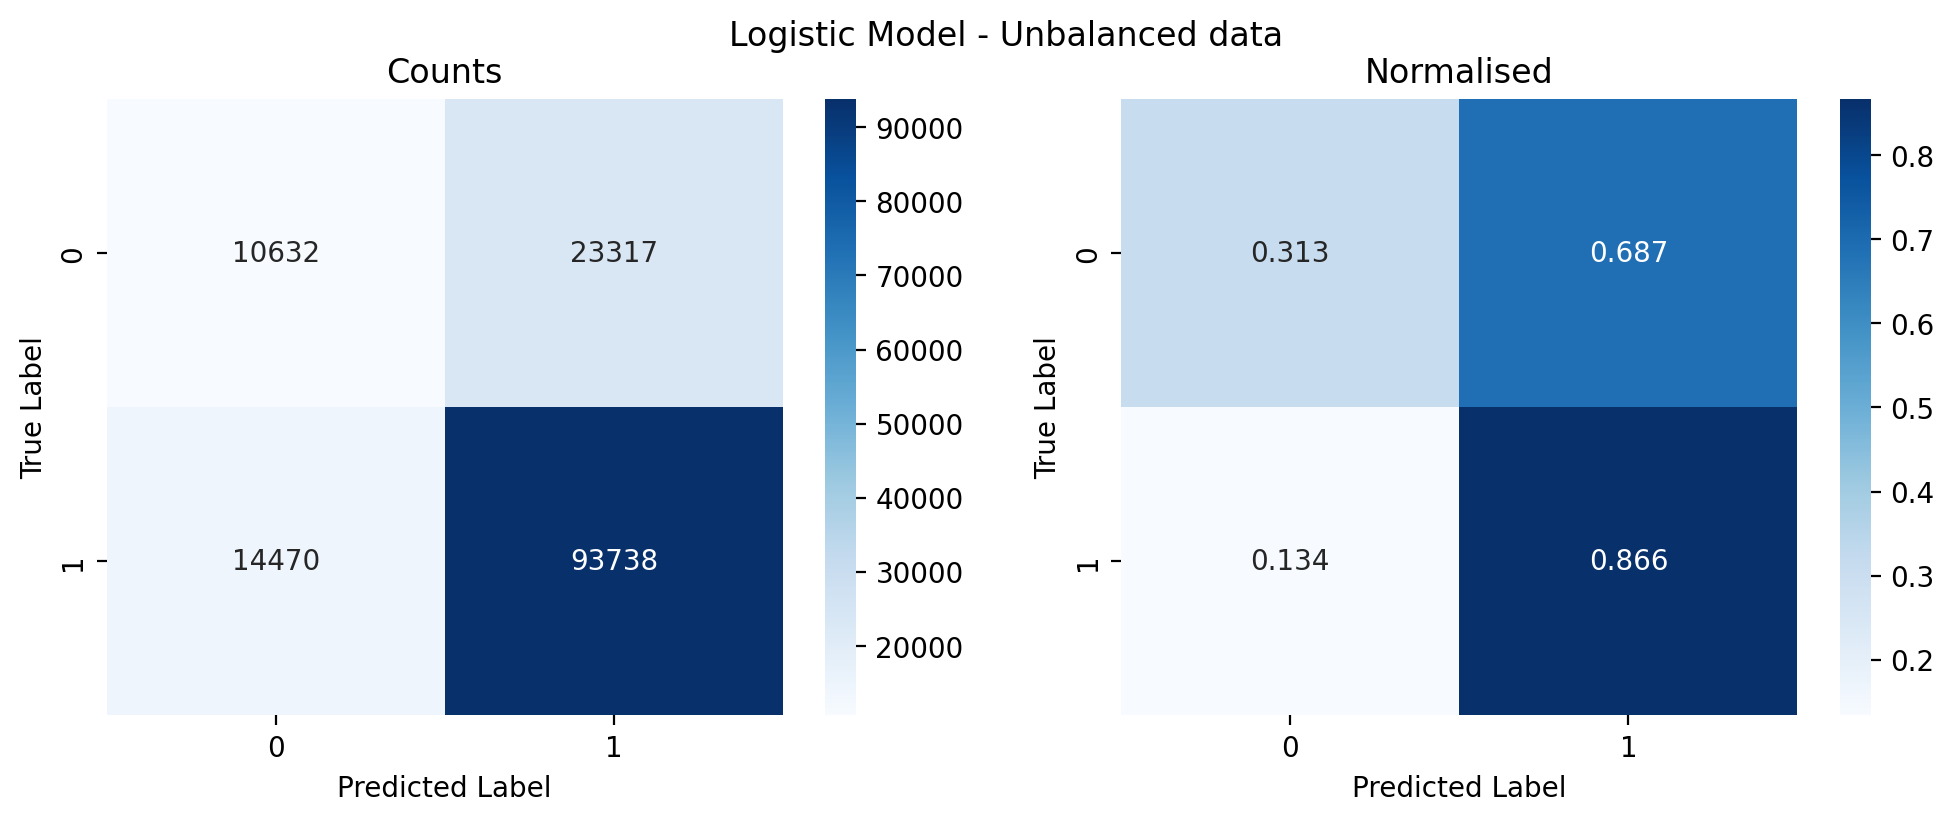

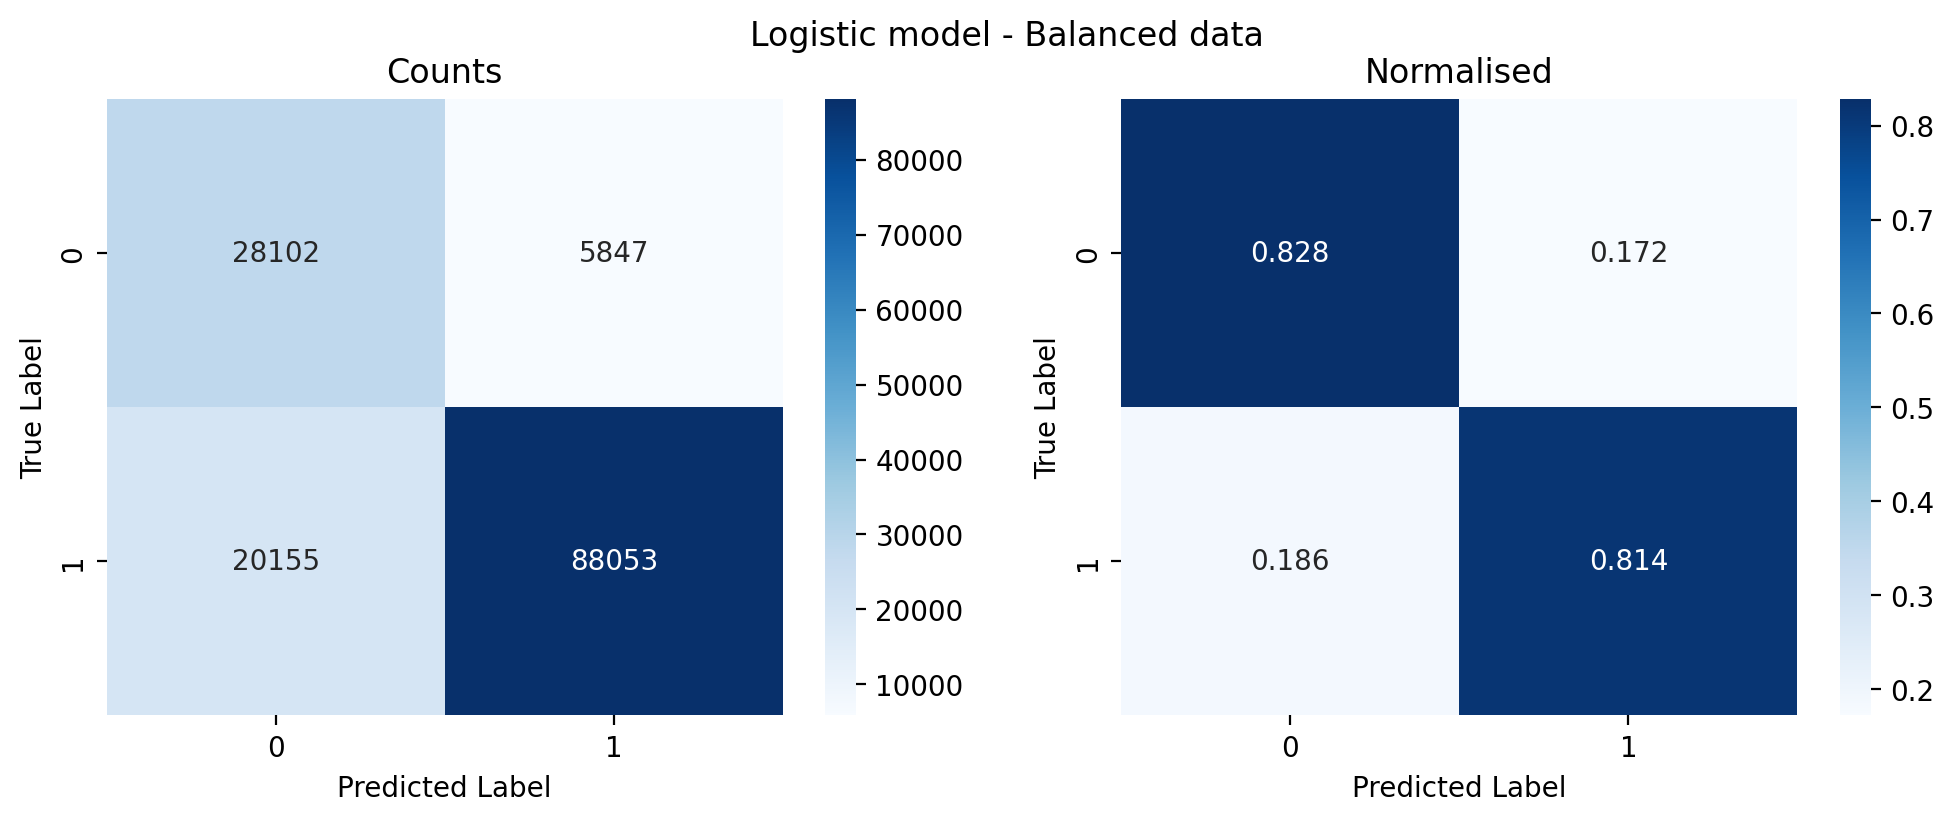

In [164]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Logistic Model - Unbalanced data")
plt.show()
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Logistic model - Balanced data")
plt.show()

we see that the first logistic regression is very good at predicting negative reviews, which is interesting as there are very few of them in comparison. however, it has overfitted, and predicts many positive reviews as negative.

The regression on the balanced data does better on positive reviews and slightly worse on negative, hwoever, it gets less wrong overall

In [26]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [27]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


We can see how the ROC changes as we change the confidence thresehold. It shows we could try vary it and compare.

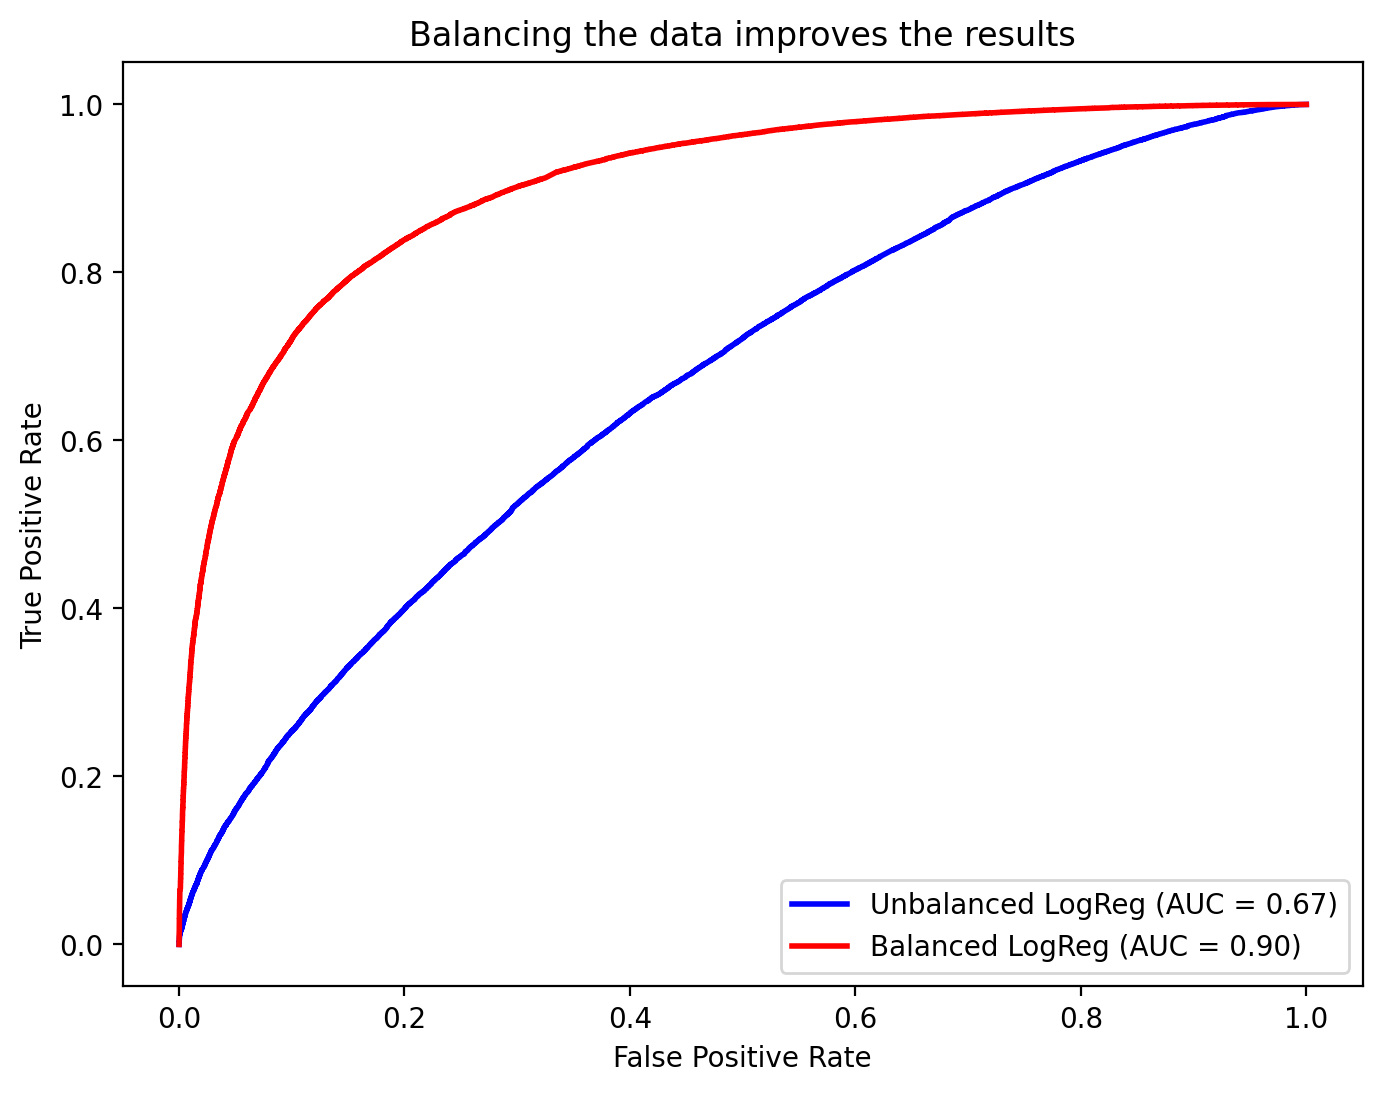

In [161]:
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced LogReg (AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced LogReg (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balancing the data improves the results')
plt.legend()


plt.show()

In [29]:
with open('logreg_roc_data.pkl', 'wb') as f:
    joblib.dump({'fpr_unbal': fpr_unbal, 'tpr_unbal': tpr_unbal, 'roc_auc1': roc_auc1,
                 'fpr_bal': fpr_bal, 'tpr_bal': tpr_bal, 'roc_auc2': roc_auc2}, f)

Really poor precision of the 0 class, and bad recall on the 1 class. It "performs well" by guessing 0 a lot. Then when its very confident it guesses 1 and gets it right, but misclassifies many positive reviews as negative.

In [30]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.42      0.31      0.36     33949
           1       0.80      0.87      0.83    108208

    accuracy                           0.73    142157
   macro avg       0.61      0.59      0.60    142157
weighted avg       0.71      0.73      0.72    142157



In [31]:
print(classification_report(y_test, y_pred_test_bal))

              precision    recall  f1-score   support

           0       0.58      0.83      0.68     33949
           1       0.94      0.81      0.87    108208

    accuracy                           0.82    142157
   macro avg       0.76      0.82      0.78    142157
weighted avg       0.85      0.82      0.83    142157



### Original unbalanced dataset:
- **Recall for negative reviews (0)**: The recall for the negative class is 0.31. This means that only 31% of the actual negative reviews were correctly identified by the model. This is a very low recall and indicates that the model missed a large number of negative reviews.
- **Precision for negative reviews (0)**: The precision is 0.42, which indicates that out of all the reviews predicted as negative, only 42% were actually negative. This is poor. We would like a better precision and recall on the negative class
- **Overall accuracy**: While the overall accuracy is 0.73, this is largely influenced by the model's performance on the dominant positive class. The high imbalance in the dataset makes accuracy a less reliable indicator of model performance.

### After downsampling the majority (1) class:
- **Recall for negative reviews (0)**: The recall increased to 0.83, indicating that the model now correctly identifies 83% of the negative reviews. This is a substantial improvement, showing that the model became much better at detecting negative reviews.
- **Precision for negative reviews (0)**: The precision for the negative class also improved to 0.58. This means a higher proportion of reviews predicted as negative are infact negative. Ideally this would be higher too, however the recall increasing so much is already a good improvement. We identified over 80% of the negative reviews, and if the model identifies a review as negative, there is a 58% chance it is infact negative.
- **Overall Accuracy**: The overall accuracy improved to 0.82, but more importantly, the improvement is balanced across both classes.

### Key Observations:
1. **Improved Recall for Minority Class**: The most notable improvement is in the recall for the negative class, which suggests that balancing the classes helped the model to better identify the negative reviews.
   
2. **Increased Precision for Minority Class**: The improved precision indicates that after balancing, the model makes fewer false positive errors for the negative class.

3. **Better Balance in Performance**: The macro average scores, which give equal weight to each class, have improved considerably. This suggests a more balanced performance across both classes, rather than the model being biased towards the majority class.

### Conclusion:
Balancing the classes by downsampling the majority class significantly improved the model's ability to identify negative reviews without drastically compromising its ability to identify positive reviews. This change led to a more balanced and effective model, especially important in applications where detecting the minority class is crucial, like in sentiment analysis of customer reviews. This is also shown in the confusion matricies and the ROC curve.

Similar results, but better overall at guessing each class.

### Plotting highest coefficients for positive and negative sentiment

In [32]:
log_clas.coef_.shape

(1, 600)

In [33]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=feature_unbal
).sort_values("coefficients", ascending=False)
# word_counts.head(30).plot(kind="bar", figsize=(15, 5), legend=False)

# plt.title("The 20 highest model coefficients indicating positive sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [34]:
word_counts2 = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=feature_unbal
).sort_values("coefficients", ascending=True)

# word_counts2.head(50).abs().plot(kind="bar", figsize=(10, 5), legend=False, color='red')

# plt.title("The 20 highest model coefficients indicating negative sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [35]:
# word_counts2.head(5).abs().plot(kind="bar", figsize=(10, 5), legend=False, color='red')

# plt.title("The 5 highest model coefficients indicating negative sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

Here are the top 5 words signifiying negative reviews. 

In [36]:
p = word_counts.head(5)
n = word_counts2.head(5)
p.columns = ['pos']
n.columns = ['neg']
p_and_n = pd.concat([p,n])


In [ ]:
# colouring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data = p_and_n.stack().reset_index()
stacked_data.columns = ['feature', 'type', 'coefficient']
stacked_data
sorted_data = stacked_data.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['cornflowerblue' if tp=="pos"  else 'coral' for tp in sorted_data['type']]

# plot
plt.figure(figsize=(10,6))
sorted_data.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("We expect these words", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.xlabel("Coefficients", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xticks(rotation=0)

plt.show()

We see that both in the positive and negative reviews the same words appear, although in slightly different orders. Many words we expect such as love, great, perfect indicate positive reviews, whilst words such as return waste dissapoint indicate a negative review. Lets look further into the predictions

These *coefficients** show the words which when present in a review, sway the model's confidence the most towards either positive (blue) or negative (orange) prediction of sentiment. Notice that this model identifies different words than the logistic regression on the unbalanced data.

**Positive Sentiment**:

The words "great", "perfect", "awesome", "excel", and "love" have the highest positive coefficients, meaning that the presence of these words in a review strongly increases the likelihood that the review will be classified as positive. "love" is the strongest predictor of a positive review in this model. When "love" is used in a review, the model is most confident that the review is positive.

**Negative Sentiment**:

Words such as "useless", "terrible", "horrible" and "return" have the most negative coefficients, indicating that these words are the strongest predictors of a review being classified as negative for this model. "poor" is the word with the biggest negative coefficient. This means when a review has the word "poor" present, the model will sway its guess towards negative.

The results for the balanced data are below. It is interesting that no 2-grams were chosen top 5. They do appear in the top 20maybe this was an unececary step and we can test this in future.

In [38]:
word_counts_bal = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=feature_bal
).sort_values("coefficients", ascending=False)

# word_counts_bal.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

# plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [39]:
word_counts_bal2 = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=feature_bal
).sort_values("coefficients", ascending=True)

# word_counts_bal2.head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

# plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [40]:
p_bal = word_counts_bal.head(5)
n_bal = word_counts_bal2.head(5)
p_bal.columns = ['pos']
n_bal.columns = ['neg']
p_and_n_bal = pd.concat([p_bal,n_bal])


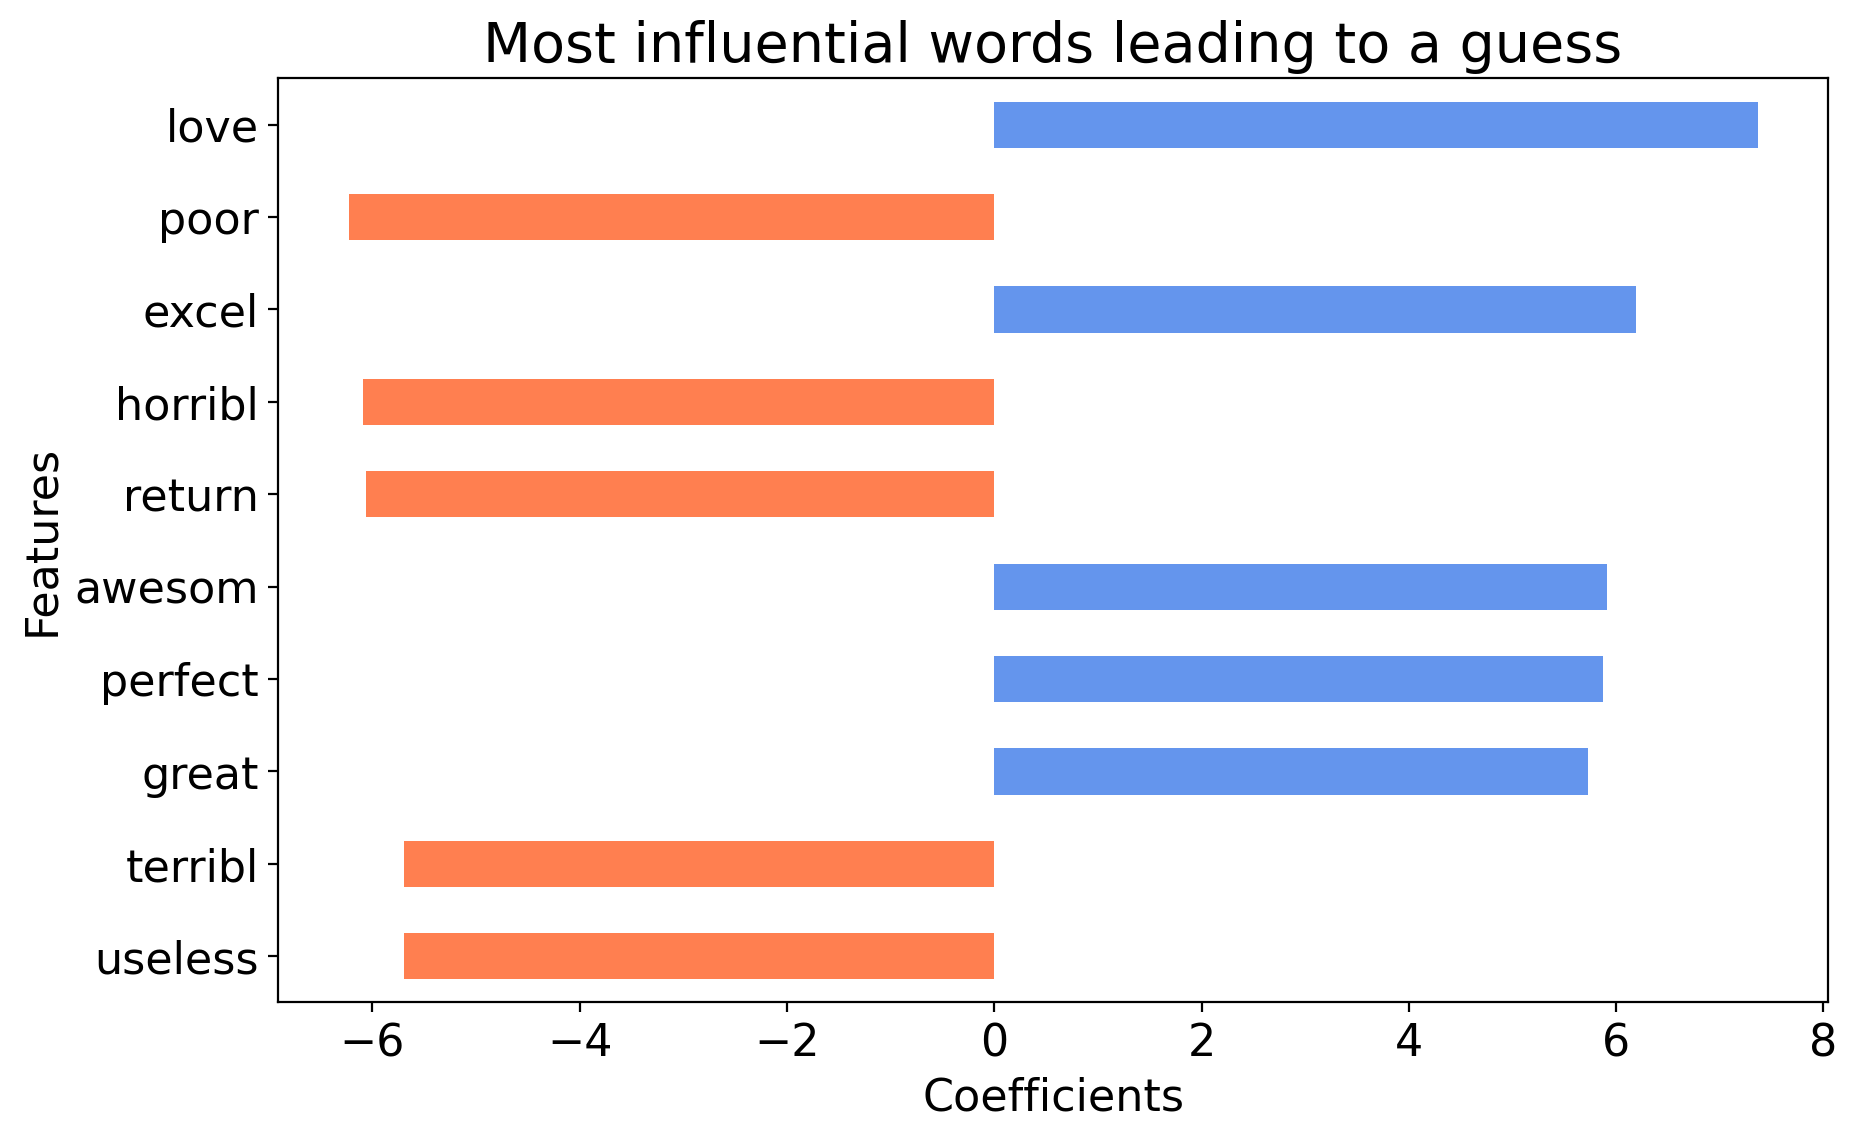

In [41]:
# colouring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data_bal = p_and_n_bal.stack().reset_index()
stacked_data_bal.columns = ['feature', 'type', 'coefficient']
stacked_data_bal
sorted_data_bal = stacked_data_bal.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['cornflowerblue' if tp=="pos"  else 'coral' for tp in sorted_data_bal['type']]

# plot
plt.figure(figsize=(10,6))
sorted_data_bal.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Most influential words leading to a guess - balanced", fontsize=20)
plt.ylabel("Features", fontsize=16)
plt.xlabel("Coefficients", fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

These *coefficients** show the words which when present in a review, sway the model's confidence the most towards either positive (blue) or negative (orange) prediction of sentiment. Notice that this model identifies different words than the logistic regression on the unbalanced data.

**Positive Sentiment**:

The words "great", "perfect", "awesome", "excel", and "love" have the highest positive coefficients, meaning that the presence of these words in a review strongly increases the likelihood that the review will be classified as positive. "love" is the strongest predictor of a positive review in this model. When "love" is used in a review, the model is most confident that the review is positive.

**Negative Sentiment**:

Words such as "useless", "terrible", "horrible" and "return" have the most negative coefficients, indicating that these words are the strongest predictors of a review being classified as negative for this model. "poor" is the word with the biggest negative coefficient. This means when a review has the word "poor" present, the model will sway its guess towards negative.

We can see then that the model does well at identifying adjectives, however it does not pickup on topic as much. We will see when analysing mistakes that when mistakes are lenghthy. I will also output both models guesses vs overall and see the mistakes it made

In [42]:
# outputting the models guesses for comparison
unbal_out = pd.concat([pd.DataFrame({"actual":y_test,"model_guess":y_pred_test }),test_later], axis=1)

In [43]:
review_vectors = pipe_final_bal[0].transform(test_later["reviewText"].fillna(''))


In [44]:
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=feature_bal, index=test_later.index)


In [45]:
output_bal = pd.concat([pd.DataFrame({"actual":y_test,"model_guess":y_pred_test_bal }),test_later[test_later.columns[:4]], review_vectors_df], axis=1)

In [46]:
joblib.dump(unbal_out, "../model/logreg_unbal_output_df.pkl")
joblib.dump(output_bal, "../model/logreg_bal_output_df.pkl")

['../model/logreg_bal_output_df.pkl']

### Understanding model mistakes:

In [47]:
y_pred_test_Ser = pd.Series(y_pred_test, index=y_test.index)


In [48]:
# getting incorrect guesses
incorrect_guesses_unbal = y_test != y_pred_test

incorrect_v_unbal = pd.Series(y_test)[incorrect_guesses_unbal]
pred_df_unbal = pd.DataFrame(y_pred_test,y_test.index)
pred_df_unbal
ig_unbal = pd.concat([pred_df_unbal[incorrect_guesses_unbal],pd.Series(incorrect_v_unbal), test_later[incorrect_guesses_unbal]], axis=1)
ig_unbal.rename(columns={0:"guess"}, inplace=True)

In [50]:
# making df of incorrect guesses
incorrect_guesses = y_test != y_pred_test_bal

incorrect_v = pd.Series(y_test)[incorrect_guesses]
pred_df = pd.DataFrame(y_pred_test_bal,y_test.index)
pred_df
ig = pd.concat([pred_df[incorrect_guesses],pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1)
ig.rename(columns={0:"guess"}, inplace=True)

In [79]:
false_positives = ig[ig["guess"]==1]
false_positives_unbal = ig_unbal[ig_unbal["guess"]==1]

In [160]:
fale_positives_common = list(set(false_positives.index).intersection(set(false_positives_unbal.index)))
fale_positives_common[:4]

[294934, 262181, 393261, 294968]

In [87]:
rev_unbal = ig_unbal.loc[688185]
text_u = rev_unbal["reviewText"]
print(f"Actual: {rev_unbal['binary']}, Guess: {rev_unbal[0]}, Overall: {int(rev_unbal['overall'])}")
print(f"Review: {text_u}")

Actual: 0, Guess: 1, Overall: 3
Review: I like matte screen protectors because they provide the best protection against fingerprints and oils from your hands. Having said that these aren't the best solution I've tried, they add the protection but are improperly cut. Though I will add a star for the amount of protectors they give you.


In [88]:
rev = ig.loc[688185]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text}")

Actual: 0, Guess: 1, Overall: 3
Review: I like matte screen protectors because they provide the best protection against fingerprints and oils from your hands. Having said that these aren't the best solution I've tried, they add the protection but are improperly cut. Though I will add a star for the amount of protectors they give you.


In [92]:
coefficients_unbal = log_clas.coef_[0]
feature_values_unbal = rev["1gram__10":]
contributions_unbal = feature_values_unbal * coefficients_unbal
contributions_unbal.sort_values(ascending=False)



1gram__best                1.588564
1gram__add                 0.773845
1gram__protect             0.330478
2gram__screen protector    0.242346
1gram__cut                 0.218947
                             ...   
1gram__said               -0.099834
1gram__screen             -0.125815
1gram__fingerprint        -0.177551
1gram__hand               -0.226591
1gram__tri                -0.380964
Name: 688185, Length: 600, dtype: object

In [94]:
cont_df_unbal = pd.DataFrame(contributions_unbal.sort_values(ascending=False))
cont_df_unbal.index=cont_df_unbal.index.str.replace('1gram__', '').str.replace('2gram__', '')

In [96]:
cont_df.head(5), cont_df.tail(5)

(        688185
 best  1.495472
 add   0.750947
 said  0.706198
 give  0.377457
 cut   0.321052,
                688185
 tri         -0.090367
 though      -0.104057
 star         -0.22396
 protector   -0.278655
 fingerprint -0.893216)

In [149]:
cont_rev_top = cont_df_unbal.head(5)
cont_rev_bottom = cont_df_unbal.tail(5)
cont_rev_top.columns = ['top']
cont_rev_bottom.columns = ['bot']
cont_rev = pd.concat([cont_rev_top,cont_rev_bottom])

In [150]:
# colouring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
cont_rev_Stack = cont_rev.stack().reset_index()
cont_rev_Stack.columns = ['feature', 'type', 'coefficient']
cont_rev_Stack
cont_rev_sorted = cont_rev_Stack.sort_values(by='coefficient', key=abs, ascending=True)


In [151]:
coefficients = log_clas_bal.coef_[0]
feature_values = rev["1gram__10":]
contributions = feature_values * coefficients
contributions.sort_values(ascending=False)



1gram__best           1.495472
1gram__add            0.750947
1gram__said           0.706198
1gram__give           0.377457
1gram__cut            0.321052
                        ...   
1gram__tri           -0.090367
1gram__though        -0.104057
1gram__star           -0.22396
1gram__protector     -0.278655
1gram__fingerprint   -0.893216
Name: 688185, Length: 600, dtype: object

In [152]:
cont_df = pd.DataFrame(contributions.sort_values(ascending=False))

In [153]:
cont_df.index=cont_df.index.str.replace('1gram__', '').str.replace('2gram__', '')

In [154]:
cont_rev_top_bal = cont_df.head(5)
cont_rev_bottom_bal = cont_df.tail(5)
cont_rev_top_bal.columns = ['top']
cont_rev_bottom_bal.columns = ['bot']
cont_rev_bal = pd.concat([cont_rev_top_bal,cont_rev_bottom_bal])

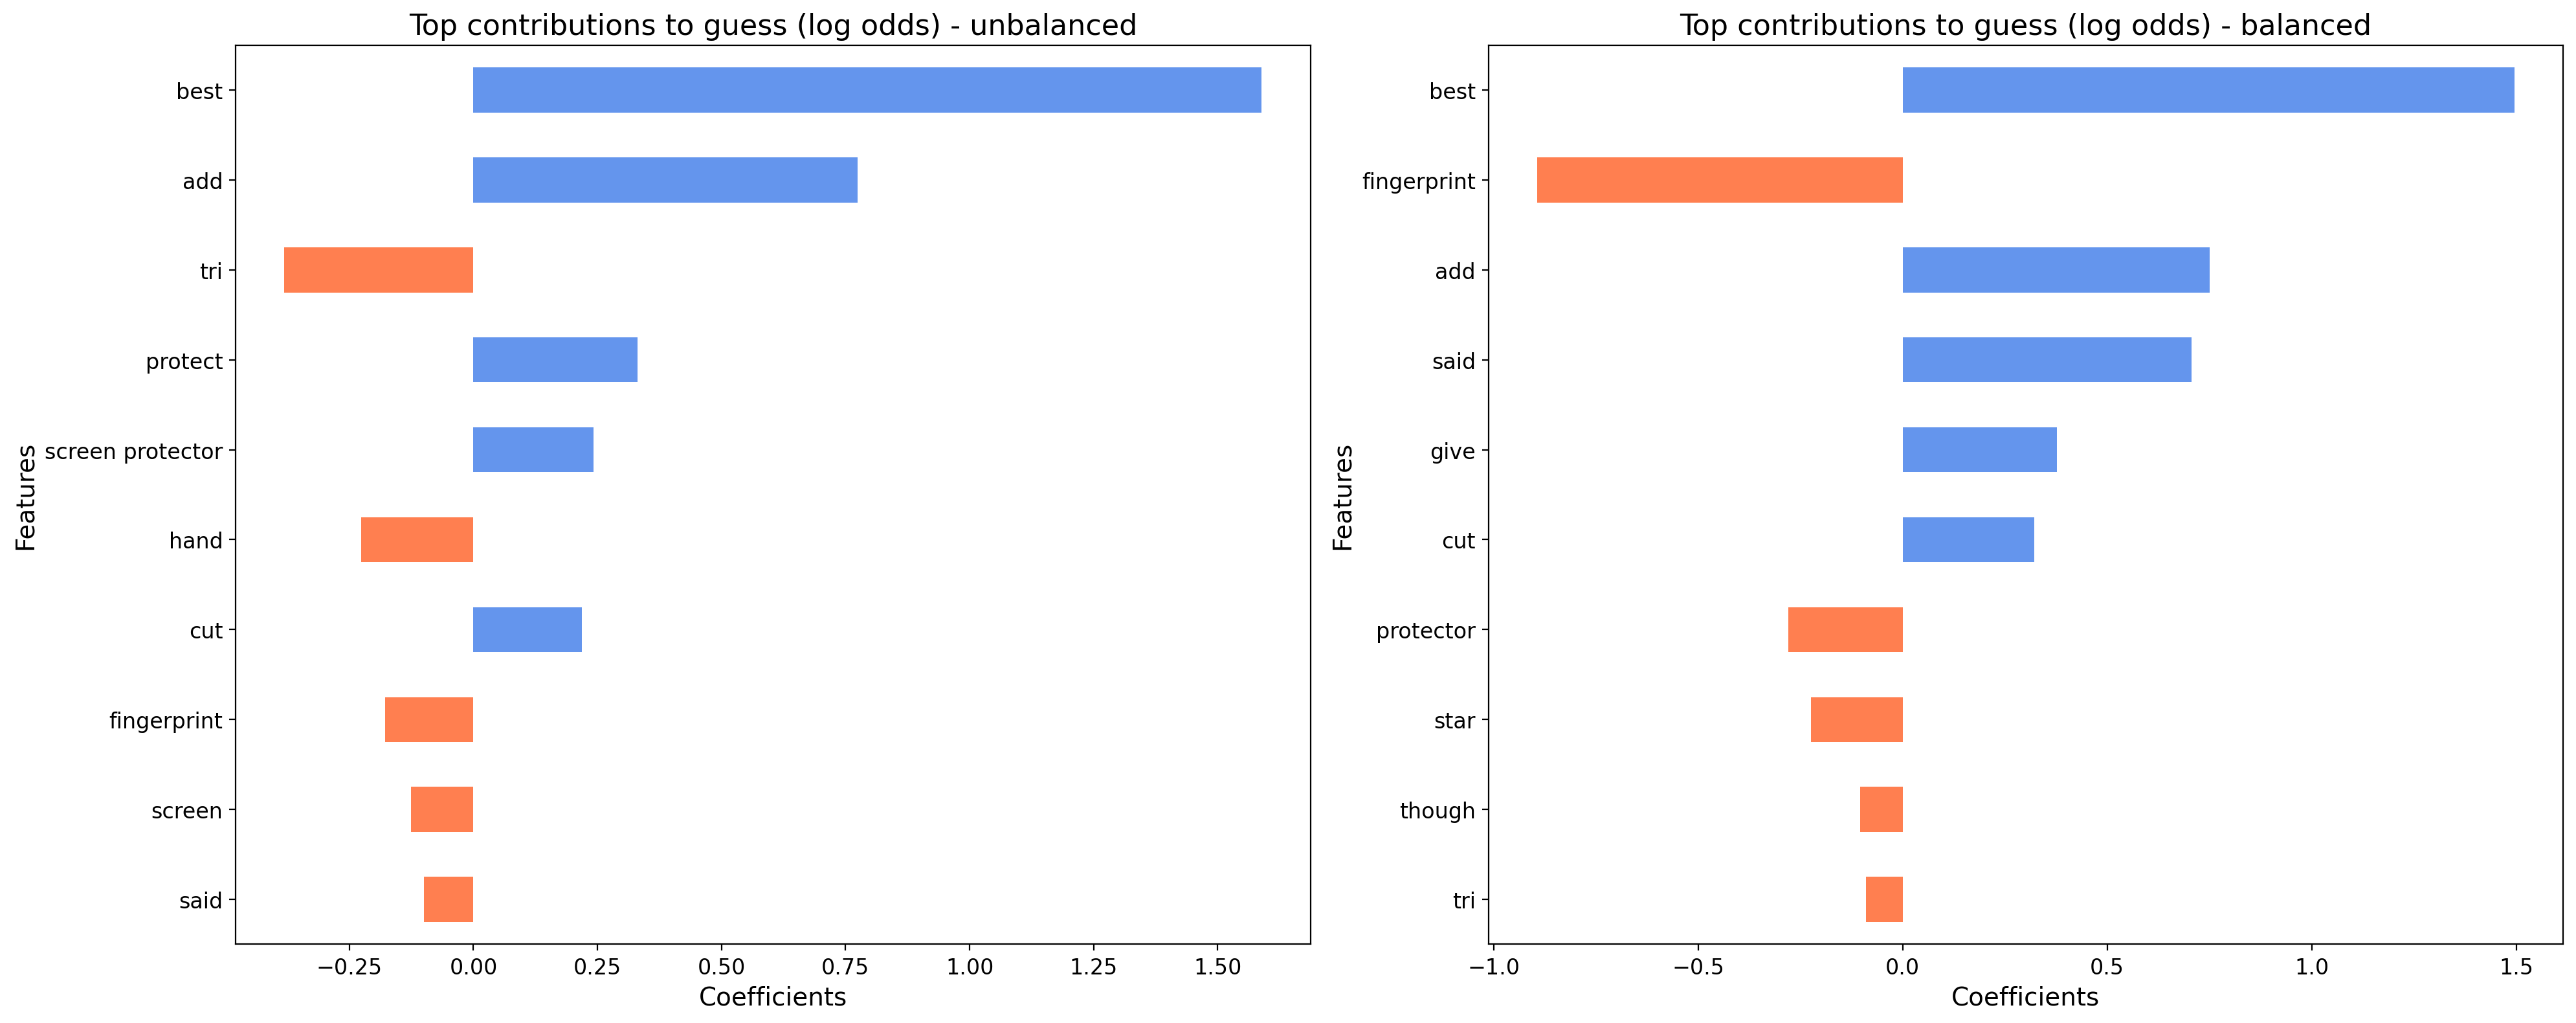

In [155]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

colors_unbal = ['cornflowerblue' if tp == "top" else 'coral' for tp in cont_rev_sorted['type']]

# unbalanced
cont_rev_sorted.set_index('feature')['coefficient'].plot(kind="barh", color=colors_unbal, legend=False, ax=axes[0])
axes[0].set_title("Top contributions to guess (log odds) - unbalanced", fontsize=16)
axes[0].set_xlabel("Coefficients", fontsize=14)
axes[0].set_ylabel("Features", fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)


colors_bal = ['cornflowerblue' if tp == "top" else 'coral' for tp in cont_rev_bal_sorted['type']]

# balanced
cont_rev_bal_sorted.set_index('feature')['coefficient'].plot(kind="barh", color=colors_bal, legend=False, ax=axes[1])
axes[1].set_title("Top contributions to guess (log odds) - balanced", fontsize=16)
axes[1].set_xlabel("Coefficients", fontsize=14)
axes[1].set_ylabel("Features", fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)


plt.tight_layout()
plt.show()


We see that the positive words swayed the confidence of the model and it misclassified it. 

In [156]:
intercept_unbal = log_clas.intercept_

total_log_odds_unbal = contributions_unbal.sum() + intercept_unbal

probability_unbal = 1 / (1 + np.exp(-total_log_odds_unbal))

In [157]:

print(f"Unbalanced log reg probability is: {probability_unbal[0]:.3f}%")

Unbalanced log reg probability is: 0.945%


In [158]:
intercept = log_clas_bal.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [159]:
print(f"Balanced log reg probability is: {probability[0]:.3f}%")

Balanced log reg probability is: 0.837%


This mistake is a great example of the models limitations. As the word "best" was in the review, the guess was skewed so much to a positive guess. Also, as the review is on the longer side, there is more chance for words to appear and skew the guess, even if their overall contribution is not that large.

As this model performs best, i have devled into a review which it has been mistaken on. Lets summarise the notebook:

## Summary:

- We optimised the hyperparameters of two logistic regergession classifers: one on the original unbalanced data, and one on the balanced downsampled data.
- We saw a significant improvement in both precision and recall when using the balanced logistic model to predict the test set, evidenced in the confusion matricies and the ROC curves. We saw that both models struggle with context, and with long sequences of text.
- However, we still managed to flag a good amount of negative reviews. These reviews could then be furhter analysed to try and extract common topics. This is a next step in this project